# Predicting Next Chords Using a Recurrent Network

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
from torchinfo import summary

from src import chord_parser

In [2]:
parser = chord_parser.Main()

In [3]:
data = pd.read_csv('../Data/data_tokenized_pitch_class.csv')
data["chords"] = data["chords"].apply(lambda x: torch.tensor(json.loads(x)))
data.head()

,url,title,artist,decade,genre,ratings,stars,chords
0,https://tabs.ultimate-guitar.com/tab/jeff-buck...,Hallelujah,Jeff Buckley,1990,Rock|Folk,51639.0,5.0,"[tensor(685), tensor(677), tensor(685), tensor..."
1,https://tabs.ultimate-guitar.com/tab/ed-sheera...,Perfect,Ed Sheeran,2010,Pop,44194.0,5.0,"[tensor(162), tensor(34), tensor(685), tensor(..."
2,https://tabs.ultimate-guitar.com/tab/elvis-pre...,Cant Help Falling In Love,Elvis Presley,1960,"Soundtrack|R&B, Funk & Soul",30059.0,5.0,"[tensor(685), tensor(162), tensor(677), tensor..."
3,https://tabs.ultimate-guitar.com/tab/eagles/ho...,Hotel California,Eagles,1970,Rock,28670.0,5.0,"[tensor(173), tensor(422), tensor(397), tensor..."
4,https://tabs.ultimate-guitar.com/tab/radiohead...,Creep,Radiohead,1990,Rock,28606.0,5.0,"[tensor(162), tensor(83), tensor(685), tensor(..."


In [4]:
augmentation_map = torch.tensor(np.load("../Data/augmentation_map.npy", allow_pickle=True))

with open("../Data/token_to_chord.json", "r") as fp:
    token_to_chord = json.load(fp)
# Convert the dictionary keys to integers
token_to_chord = {int(k): v for k, v in token_to_chord.items()}

In [5]:
VOCAB_SIZE = len(token_to_chord) + 2 # Start and end of sequence tokens
VOCAB_SIZE

1035

## Dataset

In [6]:
class ChordDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def augment(self, chords):
        """Change the root note of the chords by a random amount"""
        move_by = torch.randint(0, 12, [1]).item()
        return augmentation_map[chords, move_by]

    def pad(self, chords):
        """Pad the input tensor of shape [n] into shape [256] with zeros and special tokens"""
        out = torch.zeros((256))
        out[0] = VOCAB_SIZE - 2 # Start of sequence token
        out[1 : 1 + len(chords)] = chords
        out[1 + len(chords)] = VOCAB_SIZE - 1 # End of sequence token
        return out

    def __getitem__(self, index):
        x = self.data.iloc[index]["chords"]
        x = self.augment(x)
        return self.pad(x).long()

    def __len__(self):
        return len(self.data)

In [7]:
torch.manual_seed(42)

dataset = ChordDataset(data)

train_size = np.rint(len(dataset) * 0.8).astype(int)
train_data, test_data = random_split(dataset, [train_size, len(dataset) - train_size])

In [8]:
# Define the dataloaders
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=True)

## Model

In [9]:
class RecurrentNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.chord_embeddings = nn.Embedding(VOCAB_SIZE, 96)
        self.gru = nn.GRU(96, 96, num_layers=3, batch_first=True)
        self.mlp = nn.Sequential(
            nn.Linear(96, 96),
            nn.ReLU(),
            nn.Linear(96, VOCAB_SIZE),
        )
        
    def forward(self, x):
        x = self.chord_embeddings(x)
        x, _ = self.gru(x)
        return self.mlp(x)
    
    def predict_next(self, x):
        x = self.chord_embeddings(x)
        x, _ = self.gru(x)
        return self.mlp(x[:, -1])

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RecurrentNet().to(device)

In [11]:
input_tensor = torch.zeros((1, 256), dtype=torch.long, device=device)
summary(model, input_data=input_tensor, device=device)

Layer (type:depth-idx)                   Output Shape              Param #
RecurrentNet                             [1, 256, 1035]            --
├─Embedding: 1-1                         [1, 256, 96]              99,360
├─GRU: 1-2                               [1, 256, 96]              167,616
├─Sequential: 1-3                        [1, 256, 1035]            --
│    └─Linear: 2-1                       [1, 256, 96]              9,312
│    └─ReLU: 2-2                         [1, 256, 96]              --
│    └─Linear: 2-3                       [1, 256, 1035]            100,395
Total params: 376,683
Trainable params: 376,683
Non-trainable params: 0
Total mult-adds (M): 43.12
Input size (MB): 0.00
Forward/backward pass size (MB): 2.71
Params size (MB): 1.51
Estimated Total Size (MB): 4.22

## Trainer

In [12]:
class Trainer():
    def __init__(self, epochs, train_loader, test_loader, model, optimizer, device, lr_scheduler):
        self.epochs = epochs
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.model = model
        self.optimizer = optimizer
        self.device = device
        self.print_every = 32
        self.lr_scheduler = lr_scheduler
        
        self.step_data = {"train_losses": [], "test_losses": [], "train_accuracies": [], "test_accuracies": []}
        self.epoch_data = {"train_losses": [], "test_losses": [], "train_accuracies": [], "test_accuracies": []}
    

    def loss_mask(self, y_pred, x):
        """Get the mask for the loss function, so that the loss is not calculated for the padded elements"""
        eos_index = torch.argmax((x == VOCAB_SIZE - 1).float(), dim=1)
        range_tensor = torch.arange(y_pred.shape[1]).unsqueeze(0).expand(y_pred.shape[0], -1).to(self.device)
        mask = range_tensor <= eos_index.unsqueeze(1)
        return mask
    
    def masked_accuracy(self, y_pred, x):
        """Calculate the accuracy of the model only for the elements of the sequence"""
        y_pred, x = y_pred[:, :-1], x[:, 1:]
        eos_index = torch.argmax((x == VOCAB_SIZE - 1).float(), dim=1)
        range_tensor = torch.arange(y_pred.shape[1]).unsqueeze(0).expand(y_pred.shape[0], -1).to(self.device)
        # EOS is not included in the accuracy calculation
        mask = range_tensor < eos_index.unsqueeze(1)
        valid_elements = torch.sum(mask.float())

        same = torch.argmax(y_pred, dim=2) == x
            
        return torch.sum(same.float() * mask.float()) / valid_elements
    
    def masked_cross_entropy(self, logits, target, mask):
        """
        logits: Predictions from the model, of shape (batch_size, sequence_length, vocab_size)
        target: Ground truth labels, of shape (batch_size, sequence_length)
        mask: Binary mask indicating the non-padded parts, of shape (batch_size, sequence_length)
        """

        # Compute the raw CrossEntropyLoss
        loss = nn.CrossEntropyLoss(reduction='none')(logits.transpose(1, 2), target)

        # Apply the mask to the loss
        masked_loss = loss * mask.float()

        # Compute the mean loss over non-padded parts
        final_loss = masked_loss.sum() / mask.float().sum()

        return final_loss
    
    def train_step(self):
        self.model.train()
        for i, x in enumerate(self.train_loader):
            x = x.to(self.device)
            y_pred = self.model(x)
            mask = self.loss_mask(y_pred, x)
            
            loss = self.masked_cross_entropy(y_pred[:, :-1], x[:, 1:], mask[:, :-1])
            self.step_data["train_losses"].append(loss.item())
            
            self.step_data["train_accuracies"].append(self.masked_accuracy(y_pred, x).item())

            if i % self.print_every == self.print_every - 1:
                print(f"Batch {i + 1}/{len(self.train_loader)}, Loss: {loss.item():.4f}, Accuracy: {self.step_data['train_accuracies'][-1]:.4f}")
                            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
        self.epoch_data["train_losses"].append(np.array(self.step_data["train_losses"]).mean())
        self.epoch_data["train_accuracies"].append(np.array(self.step_data["train_accuracies"]).mean())
                   
        
    def eval_step(self):
        self.model.eval()
        for i, x in enumerate(self.test_loader):
            x = x.to(self.device)
            with torch.inference_mode():
                y_pred = self.model(x)

            mask = self.loss_mask(y_pred, x)            
            loss = self.masked_cross_entropy(y_pred[:, :-1], x[:, 1:], mask[:, :-1])
            self.step_data["test_losses"].append(loss.item())
                        
            self.step_data["test_accuracies"].append(self.masked_accuracy(y_pred, x).item())
        
        self.epoch_data["test_losses"].append(np.array(self.step_data["test_losses"]).mean())
        self.epoch_data["test_accuracies"].append(np.array(self.step_data["test_accuracies"]).mean())
                    
        
        print(f"Test Loss: {loss.item():.4f}, Accuracy: {self.step_data['test_accuracies'][-1]:.4f}")

    def plot(self):
        fig, axes = plt.subplots(2, 1, figsize=(15, 15))
        axes[0].set_title("Loss")
        sns.lineplot(x=range(len(self.epoch_data["train_losses"])), y=self.epoch_data["train_losses"], label="Train Loss", ax=axes[0])
        sns.lineplot(x=range(len(self.epoch_data["test_losses"])), y=self.epoch_data["test_losses"], label="Test Loss", ax=axes[0])

        axes[1].set_title("Total Accuracy")
        sns.lineplot(x=range(len(self.epoch_data["train_accuracies"])), y=self.epoch_data["train_accuracies"], label="Train Accuracy", ax=axes[1])
        sns.lineplot(x=range(len(self.epoch_data["test_accuracies"])), y=self.epoch_data["test_accuracies"], label="Test Accuracy", ax=axes[1])
        
    
    def init_metrics(self):
        self.step_data = {"train_losses": [], "test_losses": [], "train_accuracies": [], "test_accuracies": []}

        
    def train(self):    
        for epoch in range(self.epochs):
            print(f"Epoch {epoch + 1}/{self.epochs}\n-------------------------------")
            self.init_metrics()
            self.train_step()
            self.eval_step()
            self.lr_scheduler.step()
            
        self.plot()

## Training

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.3)
trainer = Trainer(
    epochs=50,
    train_loader=train_loader,
    test_loader=test_loader,
    model=model,
    optimizer=optimizer,
    device=device,
    lr_scheduler=lr_scheduler,
)

Epoch 1/50
-------------------------------
Batch 32/139, Loss: 4.0837, Accuracy: 0.0764
Batch 64/139, Loss: 3.5093, Accuracy: 0.1481
Batch 96/139, Loss: 3.2206, Accuracy: 0.2108
Batch 128/139, Loss: 2.6723, Accuracy: 0.2286
Test Loss: 2.9229, Accuracy: 0.1762
Epoch 2/50
-------------------------------
Batch 32/139, Loss: 2.8886, Accuracy: 0.1856
Batch 64/139, Loss: 2.6455, Accuracy: 0.2051
Batch 96/139, Loss: 2.5586, Accuracy: 0.2068
Batch 128/139, Loss: 2.5776, Accuracy: 0.2193
Test Loss: 2.5283, Accuracy: 0.2232
Epoch 3/50
-------------------------------
Batch 32/139, Loss: 2.4992, Accuracy: 0.2749
Batch 64/139, Loss: 2.3833, Accuracy: 0.3068
Batch 96/139, Loss: 2.2554, Accuracy: 0.3502
Batch 128/139, Loss: 2.4801, Accuracy: 0.3547
Test Loss: 2.2053, Accuracy: 0.3772
Epoch 4/50
-------------------------------
Batch 32/139, Loss: 2.2244, Accuracy: 0.3804
Batch 64/139, Loss: 2.0663, Accuracy: 0.4263
Batch 96/139, Loss: 2.0868, Accuracy: 0.4363
Batch 128/139, Loss: 1.8848, Accuracy: 0.4

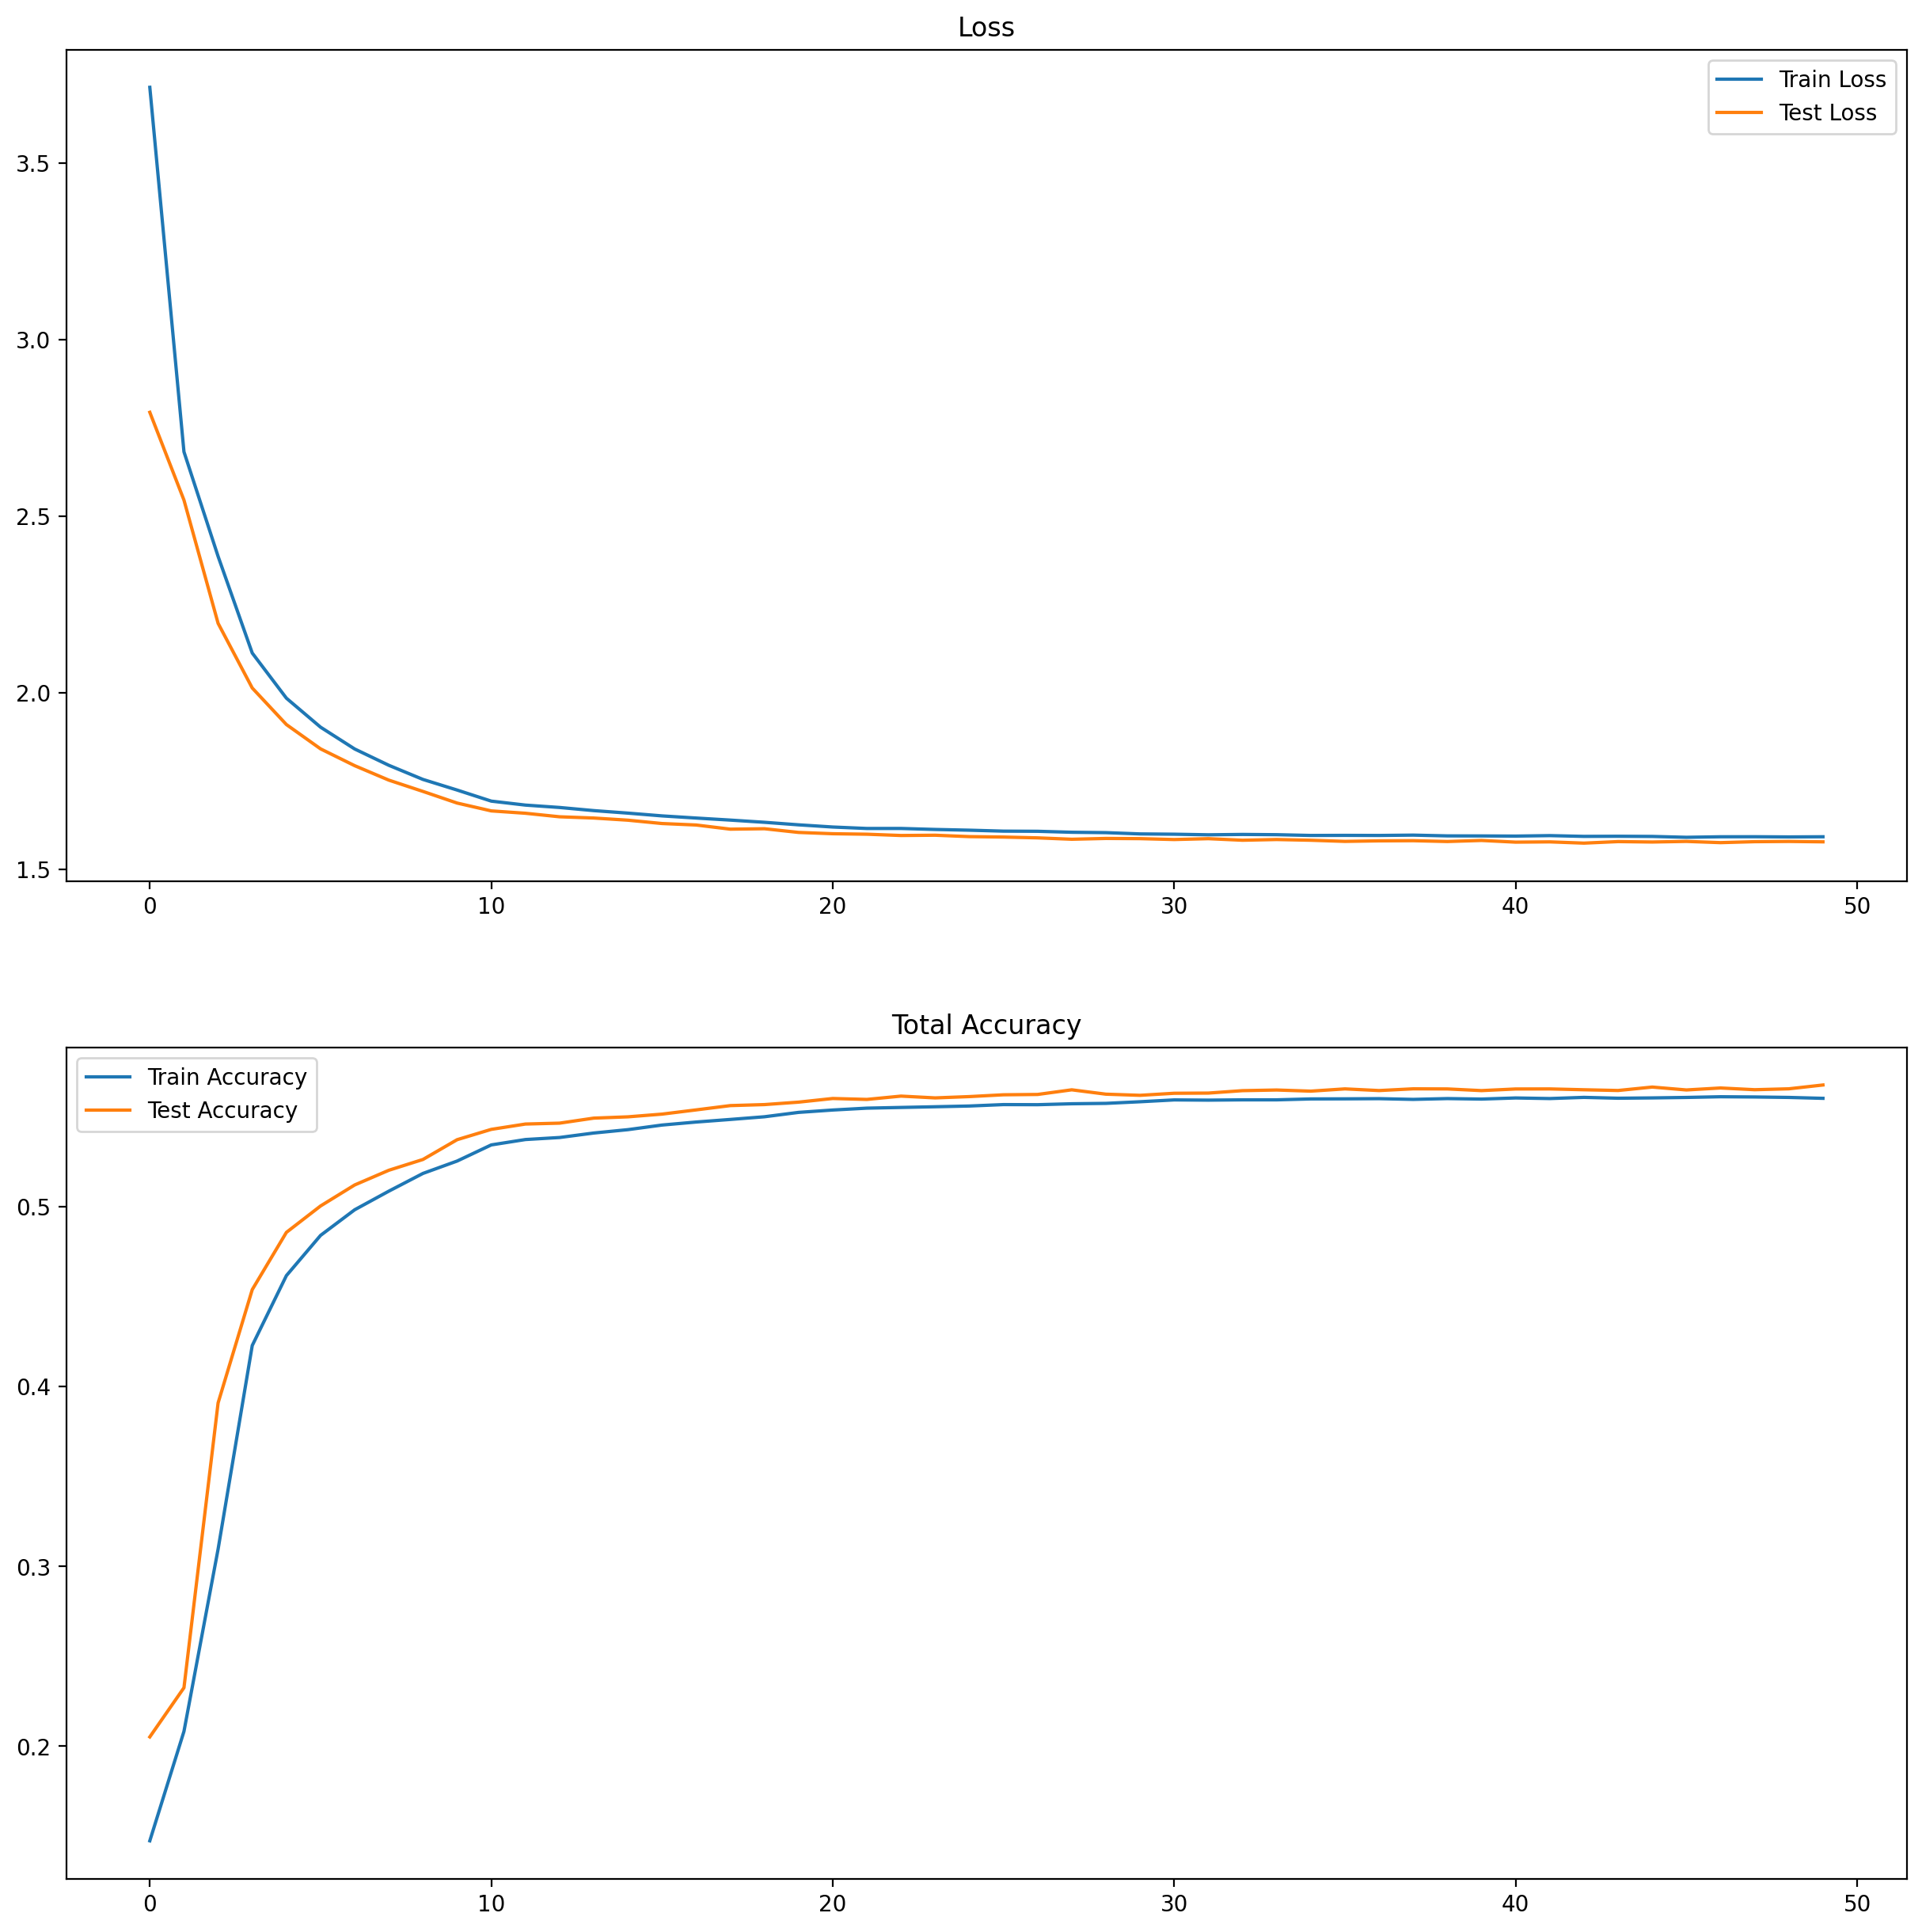

In [14]:
trainer.train()

In [15]:
torch.save(model.state_dict(), "../Models/RecurrentNet.pt")

## Inference

In [16]:
from src import seq_interpreter

interpreter = seq_interpreter.Main(parser)

In [17]:
def generate_sequence(temperature, max_length):
    model.eval()
    with torch.inference_mode():
        x = torch.zeros((1, max_length + 2), dtype=torch.long, device=device)
        # The start of sequence token
        x[:, 0] = VOCAB_SIZE - 2
        
        for i in range(max_length):
            y_pred = model(x[:, : i + 1])
            y_pred = y_pred[:, i]
            # Zero out the probability for the same as the previous chord
            y_pred[:, x[:, i]] = -torch.inf
            # Sample from the distribution
            y_pred = F.softmax(y_pred, dim=1) ** (1 / temperature)
            x[:, i + 1] = y_pred.multinomial(1).item()
            if x[:, i + 1] == VOCAB_SIZE - 1:
                break
        if VOCAB_SIZE - 1 not in x:
            x[:, -1] = VOCAB_SIZE - 1
    return x[0, 1:]

In [18]:
seq = generate_sequence(1.0, 254)
print(interpreter.token_seq_to_chords(seq))
interpreter.play_seq(seq)

D# | F | C#m | A | C#m | G# | C#m | F# | C#m | G# | C#m | F# | C#m | G# | B | A | G# | C#m | A | G# | C#m | F# | C#m | G# | G#m | F# | C#m | G#m | G# | A | C#m | G#m | A | G# | C#m | D#m | F# | G# | C#m | G# | D# | G# | D# | G# | C#m | D# | G# | D# | B | A | G# | D# | F# | G# | C#m | G# | A | G# | D# | G# | C#m | G# | B | D# | G# | F# | D | E
